In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Text processing library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eshas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_train = pd.read_csv('train.txt', header =None, sep = ';', names = ['Input','Sentiment'], encoding = 'utf-8')
df_test = pd.read_csv('test.txt', header = None, sep = ';', names = ['Input','Sentiment'], encoding = 'utf-8')
df_val = pd.read_csv('val.txt', header=None, sep = ';', names = ['Input','Sentiment'] , encoding = 'utf-8')

In [4]:
df_train.head()

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df_test.head()

,Input,Sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [6]:
df_val.head()

,Input,Sentiment
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [7]:
df_train.shape

(16000, 2)

In [8]:
df_test.shape

(2000, 2)

In [9]:
df_val.shape

(2000, 2)

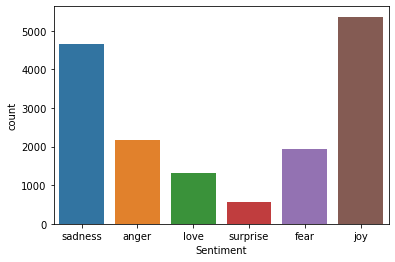

In [10]:
sns.countplot(df_train.Sentiment)
plt.show()

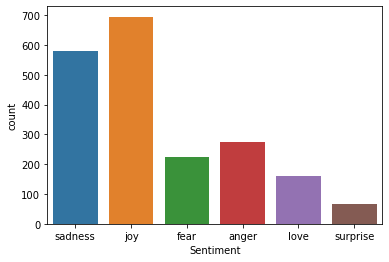

In [11]:
sns.countplot(df_test.Sentiment)
plt.show()

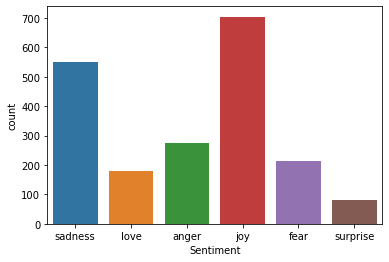

In [12]:
sns.countplot(df_val.Sentiment)
plt.show()

In [13]:
pip install text_hammer

Note: you may need to restart the kernel to use updated packages.


In [16]:
import text_hammer as th

In [19]:
# These are series of preprocessing
df_train['Input'] = df_train['Input'].apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
df_train['Input'] = df_train['Input'].apply(lambda x: th.remove_emails(x))


df_train['Input'] = df_train['Input'].apply(lambda x: th.remove_special_chars(x))
df_train['Input'] = df_train['Input'].apply(lambda x: th.remove_accented_chars(x))


In [25]:
df_train['Input'] = df_train['Input'].apply(lambda x: th.make_base(x)) #ran -> run

In [26]:
#df_train['Input'][100:] = df_train['Input'][100:].apply(lambda x: th.make_base(x)) #ran -> run

In [27]:
# These are series of preprocessing
df_test['Input'] = df_test['Input'].apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
df_test['Input'] = df_test['Input'].apply(lambda x: th.remove_emails(x))


df_test['Input'] = df_test['Input'].apply(lambda x: th.remove_special_chars(x))
df_test['Input'] = df_test['Input'].apply(lambda x: th.remove_accented_chars(x))

In [28]:
df_test['Input'] = df_test['Input'].apply(lambda x: th.make_base(x)) #ran -> run

In [29]:
df_train['Sentiment']=df_train.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_test['Sentiment']=df_test.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
df_val['Sentiment']=df_val.Sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [30]:
df_train.head()

,Input,Sentiment
0,I do nt feel humiliated,3
1,I can go from feel so hopeless to so damn hope...,3
2,I m grab a minute to post I feel greedy wrong,1
3,I am ever feel nostalgic about the fireplace I...,2
4,I am feel grouchy,1


In [31]:
df_test.head()

,Input,Sentiment
0,I m feel rather rotten so I m not very ambitio...,3
1,I m update my blog because I feel shitty,3
2,I never make she separate from I because I don...,3
3,I leave with my bouquet of red and yellow tuli...,0
4,I was feel a little vain when I do this one,3


In [32]:
from keras.preprocessing.text import Tokenizer

In [33]:
num_words = 5000 
tokenizer = Tokenizer( num_words , lower=True )
df_total = pd.concat([df_train['Input'], df_test['Input']], axis = 0)
tokenizer.fit_on_texts(df_total)

In [34]:
X_train = tokenizer.texts_to_sequences(df_train['Input'])
X_test = tokenizer.texts_to_sequences(df_test['Input'])
X_val = tokenizer.texts_to_sequences(df_val['Input'])

In [35]:
from keras.preprocessing.sequence import pad_sequences
max_pad = 100
X_train_pad = pad_sequences(X_train , maxlen = 100, padding = 'post')

X_test_pad = pad_sequences(X_test, maxlen = 100, padding = 'post')

X_val_pad = pad_sequences(X_val, maxlen = 100, padding = 'post')

In [36]:
print(X_train_pad.shape, X_val_pad.shape, X_test_pad.shape)

(16000, 100) (2000, 100) (2000, 100)


In [37]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(df_train.Sentiment.values)
y_test = to_categorical(df_test.Sentiment.values)
y_val = to_categorical(df_val.Sentiment.values)

In [38]:
print(y_train.shape,y_test.shape, y_val.shape)

(16000, 6) (2000, 6) (2000, 6)


In [39]:
y_train[0]

array([0., 0., 0., 1., 0., 0.], dtype=float32)

In [40]:
#from tensorflow.keras.layers import Embedding,LSTM,Dense
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense , Bidirectional
from keras.layers.embeddings import Embedding
import keras.backend as K

In [41]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 32 dimension
model = Sequential()
model.add(Embedding(num_words , EMBEDDING_DIM,  input_length = 100))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               481600    
_________________________________________________________________
dense (Dense)                (None, 6)                 2406      
Total params: 984,006
Trainable params: 984,006
Non-trainable params: 0
_________________________________________________________________


In [43]:
X_train_pad.shape

(16000, 100)

In [44]:
y_train.shape

(16000, 6)

In [45]:
model.fit(X_train_pad , y_train , batch_size = 128 , epochs = 10 , verbose = 2 , validation_data = (X_val_pad, y_val))

Epoch 1/10
125/125 - 133s - loss: 1.5633 - accuracy: 0.3705 - val_loss: 1.3386 - val_accuracy: 0.5110
Epoch 2/10
125/125 - 98s - loss: 0.8735 - accuracy: 0.6863 - val_loss: 0.8220 - val_accuracy: 0.6830
Epoch 3/10
125/125 - 103s - loss: 0.4765 - accuracy: 0.8391 - val_loss: 0.5588 - val_accuracy: 0.8100
Epoch 4/10
125/125 - 98s - loss: 0.2693 - accuracy: 0.9073 - val_loss: 0.4728 - val_accuracy: 0.8450
Epoch 5/10
125/125 - 102s - loss: 0.1879 - accuracy: 0.9344 - val_loss: 0.4407 - val_accuracy: 0.8595
Epoch 6/10
125/125 - 98s - loss: 0.1417 - accuracy: 0.9506 - val_loss: 0.4751 - val_accuracy: 0.8535
Epoch 7/10
125/125 - 97s - loss: 0.1141 - accuracy: 0.9588 - val_loss: 0.4698 - val_accuracy: 0.8615
Epoch 8/10
125/125 - 98s - loss: 0.0990 - accuracy: 0.9662 - val_loss: 0.4457 - val_accuracy: 0.8690
Epoch 9/10
125/125 - 98s - loss: 0.0838 - accuracy: 0.9722 - val_loss: 0.4891 - val_accuracy: 0.8630
Epoch 10/10
125/125 - 99s - loss: 0.0713 - accuracy: 0.9756 - val_loss: 0.5207 - val_acc

In [46]:
model.evaluate(X_test_pad, y_test) 

63/63 [==============================] - 5s 80ms/step - loss: 0.4100 - accuracy: 0.8855


[0.4100237190723419, 0.8855000138282776]

In [47]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)

In [48]:
y_true = np.argmax(y_test, axis = 1)

In [49]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91       716
           1       0.85      0.92      0.88       254
           2       0.71      0.71      0.71       160
           3       0.92      0.95      0.94       559
           4       0.90      0.82      0.86       245
           5       0.70      0.70      0.70        66

    accuracy                           0.89      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.89      0.89      0.89      2000



In [50]:
model.save("E:/Emotion_Detection.h5")

In [51]:
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key


In [52]:
def predict(sentence):
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=300,padding='post')
    ans=get_key(model.predict_classes(sentence_padded))
    print("The emotion predicted is",ans)

In [53]:
predict(str(input('Enter a sentence : ')))

Enter a sentence : I hate you
The emotion predicted is anger


In [57]:
predict(str(input('Enter a sentence : ')))

Enter a sentence : love
The emotion predicted is love
